# MACD Calculator

[*********************100%%**********************]  1 of 1 completed


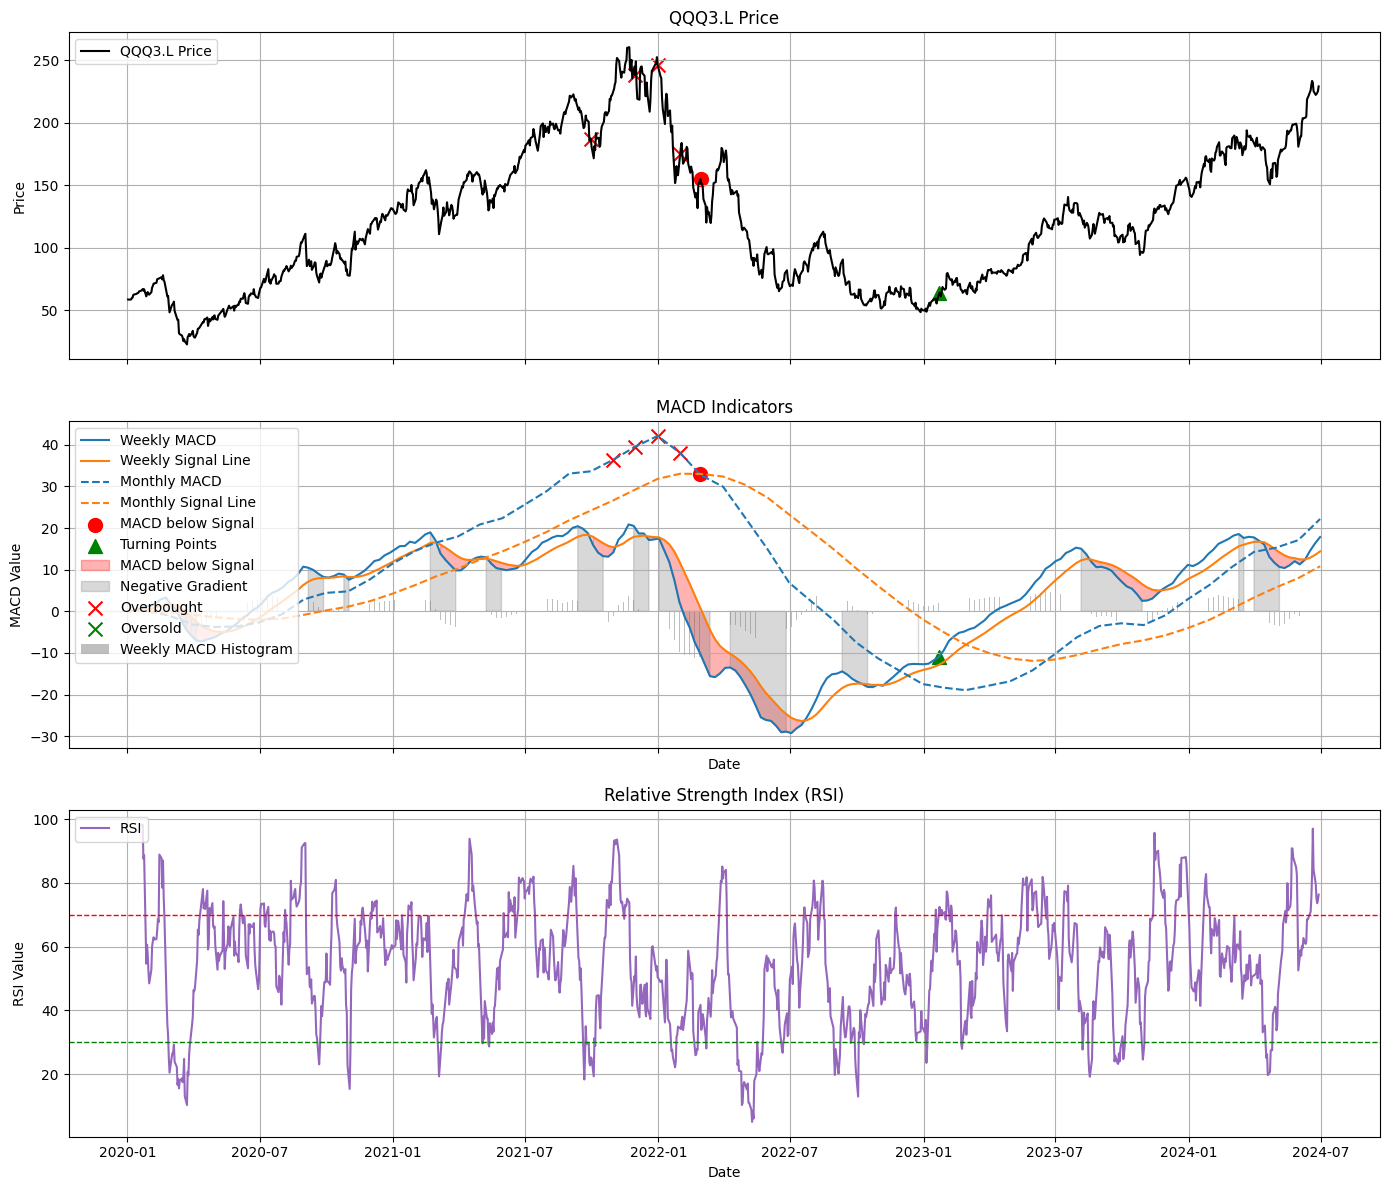

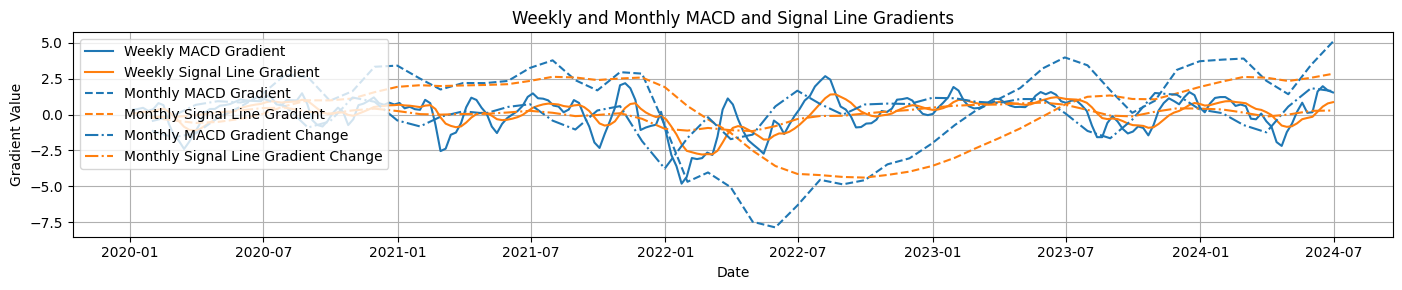

In [347]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime
import numpy as np

def calculate_macd(df, short_window=12, long_window=26, signal_window=9):
    """
    Calculate the MACD and Signal Line indicators
    """
    df['EMA_short'] = df['Close'].ewm(span=short_window, adjust=False).mean()
    df['EMA_long'] = df['Close'].ewm(span=long_window, adjust=False).mean()
    df['MACD'] = df['EMA_short'] - df['EMA_long']
    df['Signal_Line'] = df['MACD'].ewm(span=signal_window, adjust=False).mean()
    return df

def find_exact_crossover_points(df, threshold=0.01):
    """
    Find the exact crossover points where MACD crosses the Signal Line using interpolation
    """
    downcrosses = []
    for i in range(1, len(df)):
        macd_prev = df['MACD'].iloc[i-1]
        signal_prev = df['Signal_Line'].iloc[i-1]
        macd_current = df['MACD'].iloc[i]
        signal_current = df['Signal_Line'].iloc[i]
        
        # Downcrosses
        if macd_prev > signal_prev and macd_current < signal_current:
            if abs(macd_prev - signal_prev) > threshold:
                macd_diff = macd_current - macd_prev
                signal_diff = signal_current - signal_prev
                crossover_time = df.index[i-1] + (df.index[i] - df.index[i-1]) * (macd_prev - signal_prev) / (signal_diff - macd_diff)
                crossover_time = pd.Timestamp(crossover_time).round('D')
                crossover_value = macd_prev + (macd_current - macd_prev) * (crossover_time - df.index[i-1]).total_seconds() / (df.index[i] - df.index[i-1]).total_seconds()
                downcrosses.append((crossover_time, crossover_value))
                
    return downcrosses

def calculate_gradients(df):
    """
    Calculate the gradient (slope) and the rate of change of the gradient of the MACD and Signal Line
    """
    df['MACD_Gradient'] = np.gradient(df['MACD'])
    df['Signal_Line_Gradient'] = np.gradient(df['Signal_Line'])
    df['MACD_Gradient_Change'] = np.gradient(df['MACD_Gradient'])
    df['Signal_Line_Gradient_Change'] = np.gradient(df['Signal_Line_Gradient'])
    return df

def calculate_rsi(df, window=14):
    """
    Calculate the Relative Strength Index (RSI)
    """
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    return df

def find_nearest_index(df, target_date):
    """
    Find the nearest index to a given date
    """
    return df.index.get_loc(df.index[df.index.get_indexer([target_date], method='nearest')[0]])

def plot_price_macd_rsi(df_price, df_weekly, df_monthly, df_rsi, downcrosses, confirmed_turning_points, overbought_periods):
    """
    Plot the stock price along with weekly and monthly MACD indicators and RSI
    """
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
    
    ax1.plot(df_price.index, df_price['Close'], label=f'{ticker} Price', color='black')
    ax1.set_title(f'{ticker} Price')
    ax1.set_ylabel('Price')
    ax1.legend(loc='upper left')
    ax1.grid(True)
    
    # Mark the confirmed turning points on the stock price graph
    for crossover in confirmed_turning_points:
        nearest_index = find_nearest_index(df_price, crossover[0])
        ax1.scatter(df_price.index[nearest_index], df_price['Close'].iloc[nearest_index], color='green', marker='^', s=100)
    
    # Mark the exact crossover points where the monthly MACD falls below the monthly Signal line with red circles
    for crossover in downcrosses:
        nearest_index = find_nearest_index(df_price, crossover[0])
        ax1.scatter(df_price.index[nearest_index], df_price['Close'].iloc[nearest_index], color='red', marker='o', s=100)
    
    # Mark overbought conditions on the stock price graph
    for start, end in overbought_periods:
        overbought_dates = df_price.loc[start:end].index
        ax1.scatter(overbought_dates, df_price.loc[overbought_dates, 'Close'], color='red', marker='x', s=100, label='Overbought')
    
    ax2.plot(df_weekly.index, df_weekly['MACD'], label='Weekly MACD', color='tab:blue', linewidth=1.5)
    ax2.plot(df_weekly.index, df_weekly['Signal_Line'], label='Weekly Signal Line', color='tab:orange', linestyle='-', linewidth=1.5)
    ax2.bar(df_weekly.index, df_weekly['MACD'] - df_weekly['Signal_Line'], label='Weekly MACD Histogram', color='grey', alpha=0.5)
    
    ax2.plot(df_monthly.index, df_monthly['MACD'], label='Monthly MACD', color='tab:blue', linestyle='--', linewidth=1.5)
    ax2.plot(df_monthly.index, df_monthly['Signal_Line'], label='Monthly Signal Line', color='tab:orange', linestyle='--', linewidth=1.5)
    
    # Mark the exact crossover points where the monthly MACD falls below the monthly Signal line
    downcross_dates = [date for date, value in downcrosses]
    downcross_values = [value for date, value in downcrosses]
    ax2.scatter(downcross_dates, downcross_values, color='red', marker='o', s=100, label='MACD below Signal')
    
    # Mark the turning points on the MACD graph
    turning_point_dates = [date for date, value in confirmed_turning_points]
    turning_point_values = [value for date, value in confirmed_turning_points]
    ax2.scatter(turning_point_dates, turning_point_values, color='green', marker='^', s=100, label='Turning Points')
    
    # Highlight regions where the weekly MACD is below the signal line
    ax2.fill_between(df_weekly.index, df_weekly['MACD'], df_weekly['Signal_Line'], 
                     where=(df_weekly['MACD'] < df_weekly['Signal_Line']), 
                     color='red', alpha=0.3, label='MACD below Signal')
    
    # Highlight regions where the weekly MACD has a negative gradient
    ax2.fill_between(df_weekly.index, df_weekly['MACD'], 
                     where=(df_weekly['MACD_Gradient'] < 0), 
                     color='grey', alpha=0.3, label='Negative Gradient')
    
    # Mark overbought/oversold conditions on the monthly MACD graph
    overbought_dates = df_monthly.index[(df_monthly['MACD'] > df_monthly['Signal_Line']) & (df_monthly['MACD'] > 2 * df_monthly['MACD'].std())]
    oversold_dates = df_monthly.index[(df_monthly['MACD'] < df_monthly['Signal_Line']) & (df_monthly['MACD'] < -2 * df_monthly['MACD'].std())]
    ax2.scatter(overbought_dates, df_monthly.loc[overbought_dates, 'MACD'], color='red', marker='x', s=100, label='Overbought')
    ax2.scatter(oversold_dates, df_monthly.loc[oversold_dates, 'MACD'], color='green', marker='x', s=100, label='Oversold')
    
    ax2.set_title('MACD Indicators')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('MACD Value')
    ax2.legend(loc='upper left')
    ax2.grid(True)
    
    ax3.plot(df_rsi.index, df_rsi['RSI'], label='RSI', color='tab:purple', linewidth=1.5)
    ax3.axhline(70, color='red', linestyle='--', linewidth=1)
    ax3.axhline(30, color='green', linestyle='--', linewidth=1)
    ax3.set_title('Relative Strength Index (RSI)')
    ax3.set_xlabel('Date')
    ax3.set_ylabel('RSI Value')
    ax3.legend(loc='upper left')
    ax3.grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_gradients(df_weekly, df_monthly):
    """
    Plot the gradients of the weekly and monthly MACD and Signal Line
    """
    fig, ax = plt.subplots(figsize=(14, 3))  # Adjusted height to 3
    
    ax.plot(df_weekly.index, df_weekly['MACD_Gradient'], label='Weekly MACD Gradient', color='tab:blue', linewidth=1.5)
    ax.plot(df_weekly.index, df_weekly['Signal_Line_Gradient'], label='Weekly Signal Line Gradient', color='tab:orange', linestyle='-', linewidth=1.5)
    
    ax.plot(df_monthly.index, df_monthly['MACD_Gradient'], label='Monthly MACD Gradient', color='tab:blue', linestyle='--', linewidth=1.5)
    ax.plot(df_monthly.index, df_monthly['Signal_Line_Gradient'], label='Monthly Signal Line Gradient', color='tab:orange', linestyle='--', linewidth=1.5)
    
    ax.plot(df_monthly.index, df_monthly['MACD_Gradient_Change'], label='Monthly MACD Gradient Change', color='tab:blue', linestyle='-.', linewidth=1.5)
    ax.plot(df_monthly.index, df_monthly['Signal_Line_Gradient_Change'], label='Monthly Signal Line Gradient Change', color='tab:orange', linestyle='-.', linewidth=1.5)
    
    ax.set_title('Weekly and Monthly MACD and Signal Line Gradients')
    ax.set_xlabel('Date')
    ax.set_ylabel('Gradient Value')
    ax.legend(loc='upper left')
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    ticker = 'QQQ3.L'
    start_date = '2020-01-01'
    end_date = datetime.today().strftime('%Y-%m-%d')
    df = yf.download(ticker, start=start_date, end=end_date)
    
    df_weekly = df.resample('W').last()
    df_monthly = df.resample('M').last()
    
    df_weekly = calculate_macd(df_weekly)
    df_monthly = calculate_macd(df_monthly)
    
    df_weekly = calculate_gradients(df_weekly)
    df_monthly = calculate_gradients(df_monthly)
    
    df_rsi = calculate_rsi(df.copy())
    
    downcrosses = find_exact_crossover_points(df_monthly)
    
    # Use linear interpolation to estimate the gradient at the crossover points
    def interpolate_gradient(df, timestamp):
        if timestamp in df.index:
            return df.loc[timestamp, 'MACD_Gradient']
        else:
            before = df.index[df.index < timestamp][-1]
            after = df.index[df.index > timestamp][0]
            gradient_before = df.loc[before, 'MACD_Gradient']
            gradient_after = df.loc[after, 'MACD_Gradient']
            weight = (timestamp - before) / (after - before)
            return gradient_before * (1 - weight) + gradient_after * weight
    
    def interpolate_gradient_change(df, timestamp):
        if timestamp in df.index:
            return df.loc[timestamp, 'MACD_Gradient_Change']
        else:
            before = df.index[df.index < timestamp][-1]
            after = df.index[df.index > timestamp][0]
            gradient_change_before = df.loc[before, 'MACD_Gradient_Change']
            gradient_change_after = df.loc[after, 'MACD_Gradient_Change']
            weight = (timestamp - before) / (after - before)
            return gradient_change_before * (1 - weight) + gradient_change_after * weight
    
    # Calculate median of the monthly MACD gradients
    median_gradient = df_monthly['MACD_Gradient'].median()
    gradient_threshold = -0.9*median_gradient  # or use a multiple of the median, e.g., 1.5 * median_gradient
    
    # Find confirmed turning points that meet the additional conditions
    confirmed_turning_points = []
    for i in range(1, len(df_weekly)):
        if df_weekly['MACD'].iloc[i] < 0 and df_weekly['MACD_Gradient'].iloc[i] > 0:
            nearest_monthly_index = find_nearest_index(df_monthly, df_weekly.index[i])
            if df_monthly['MACD_Gradient'].iloc[nearest_monthly_index] > gradient_threshold:
                confirmed_turning_points.append((df_weekly.index[i], df_weekly['MACD'].iloc[i]))
    
    # Ensure only one green triangle signal before or after a red dot
    final_turning_points = []
    for downcross in downcrosses:
        closest_turning_point = None
        min_time_diff = pd.Timedelta(days=365)  # Arbitrary large time difference
        for turning_point in confirmed_turning_points:
            time_diff = abs(downcross[0] - turning_point[0])
            if time_diff < min_time_diff:
                closest_turning_point = turning_point
                min_time_diff = time_diff
        if closest_turning_point:
            final_turning_points.append(closest_turning_point)
            confirmed_turning_points.remove(closest_turning_point)
    
    # Identify overbought periods based on monthly MACD
    overbought_periods = []
    overbought_dates = df_monthly.index[(df_monthly['MACD'] > df_monthly['Signal_Line']) & (df_monthly['MACD'] > 1.98 * df_monthly['MACD'].std())]
    if len(overbought_dates) > 1:
        start = overbought_dates[0]
        for i in range(1, len(overbought_dates)):
            if (overbought_dates[i] - overbought_dates[i-1]).days > 1:
                end = overbought_dates[i-1]
                overbought_periods.append((start, end))
                start = overbought_dates[i]
        overbought_periods.append((start, overbought_dates[-1]))
    
    plot_price_macd_rsi(df, df_weekly, df_monthly, df_rsi, downcrosses, final_turning_points, overbought_periods)
    plot_gradients(df_weekly, df_monthly)

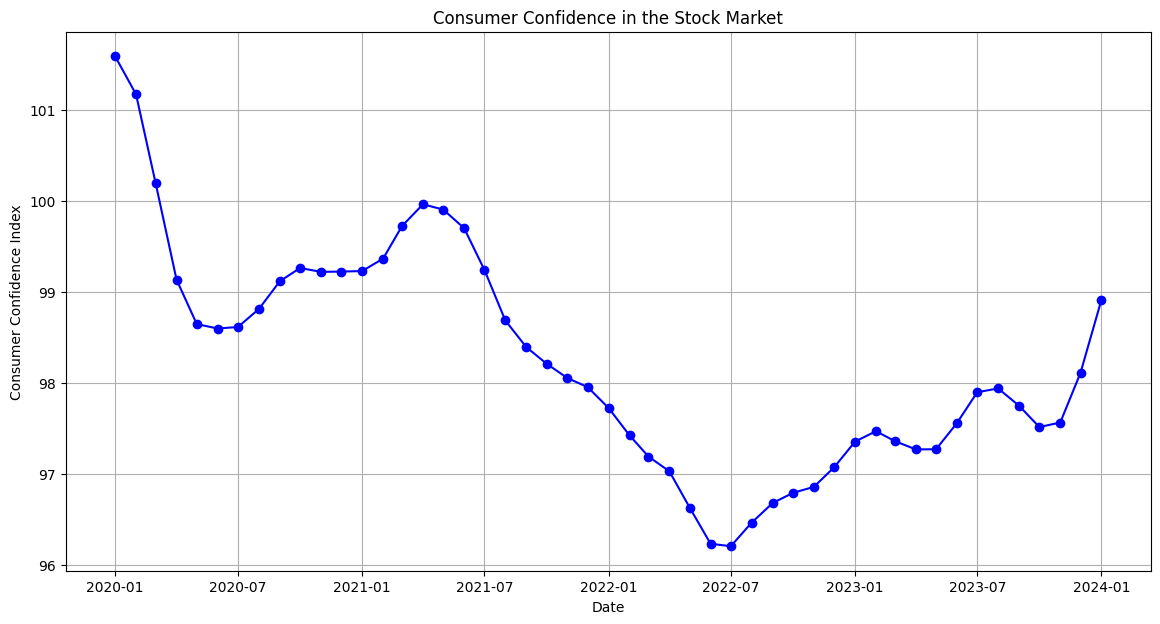

In [355]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import fred

# Fetch consumer confidence data from FRED
series_id = 'CSCICP03USM665S'  # Consumer confidence index for the United States

consumer_confidence = fred.FredReader(series_id, start=start_date, end=end_date).read()

# Rename the column for convenience
consumer_confidence.rename(columns={series_id: 'Consumer_Confidence'}, inplace=True)

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(consumer_confidence.index, consumer_confidence['Consumer_Confidence'], marker='o', linestyle='-', color='b')
plt.title('Consumer Confidence in the Stock Market')
plt.xlabel('Date')
plt.ylabel('Consumer Confidence Index')
plt.grid(True)
plt.show()

[*********************100%%**********************]  1 of 1 completed


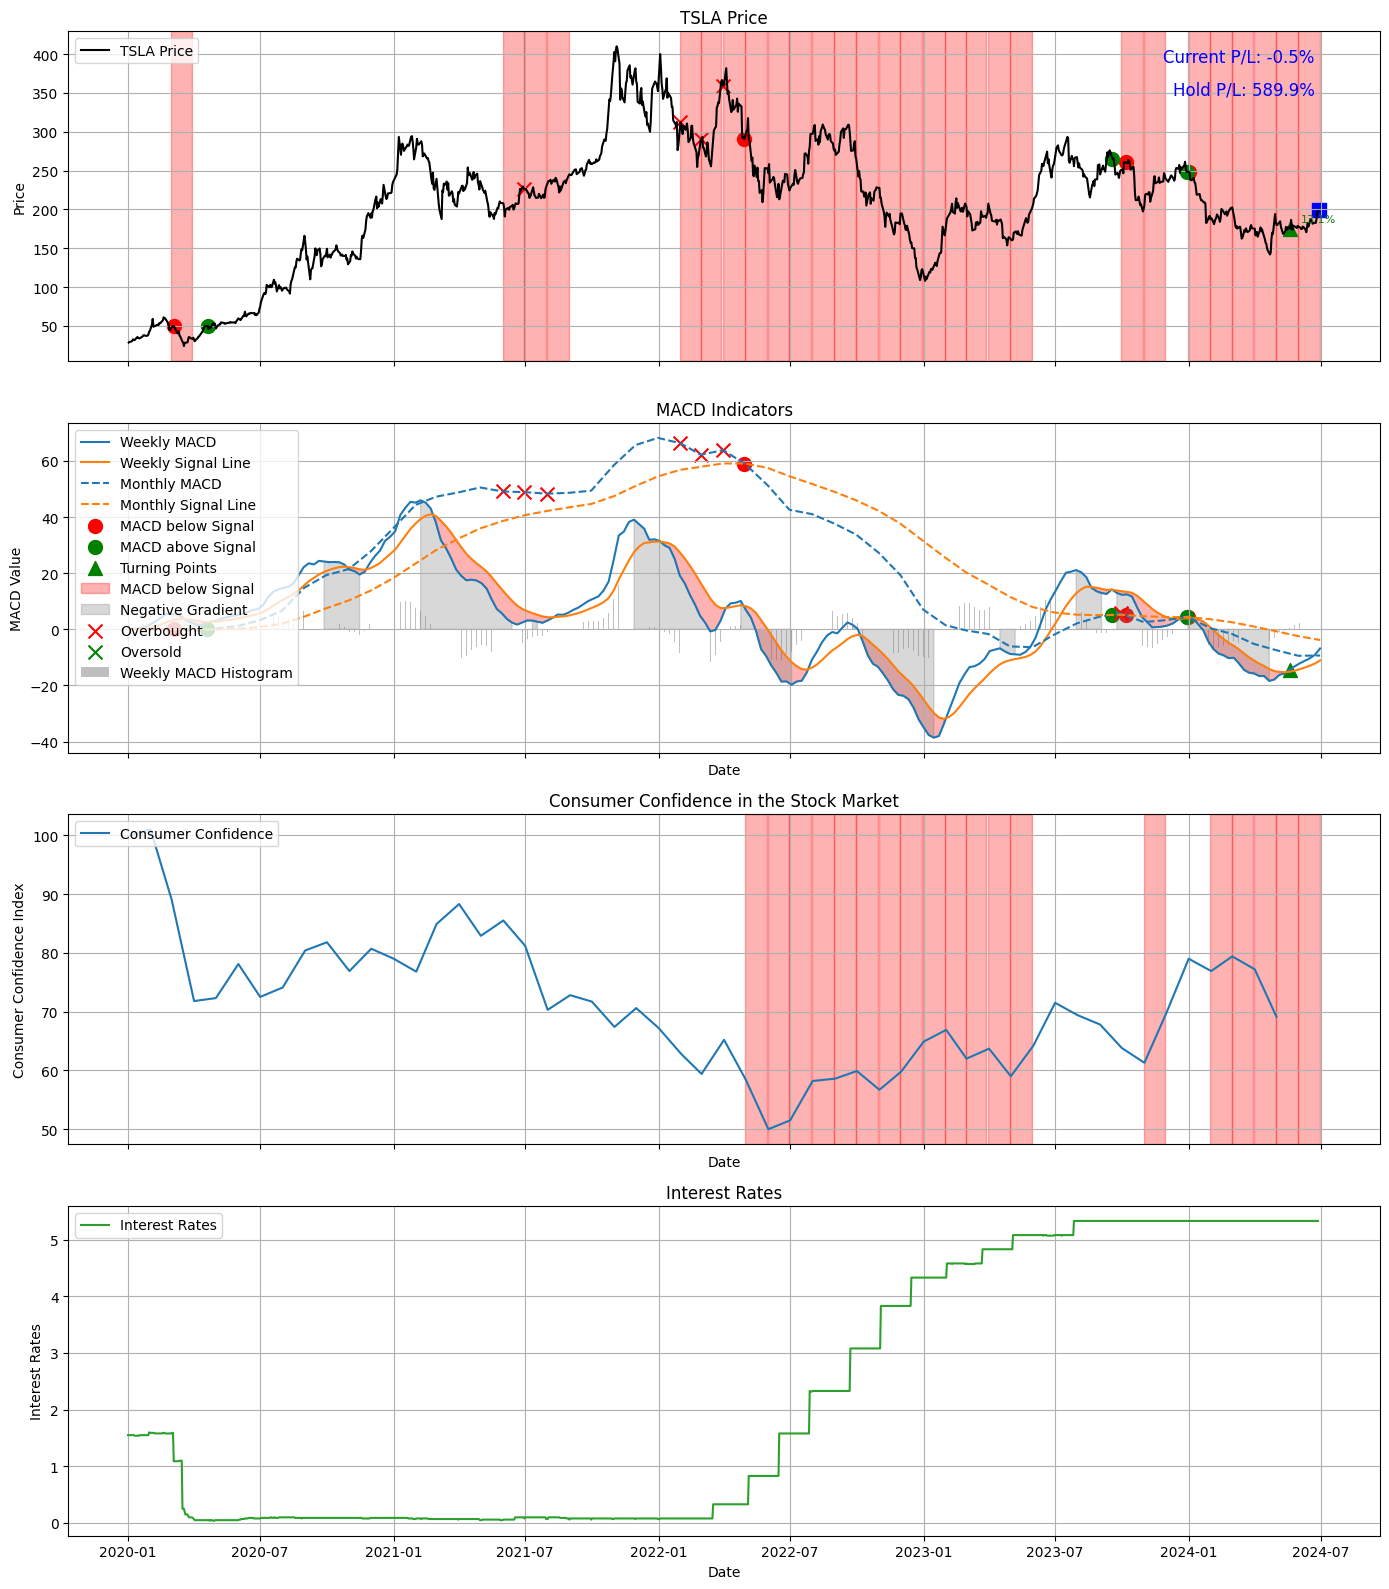

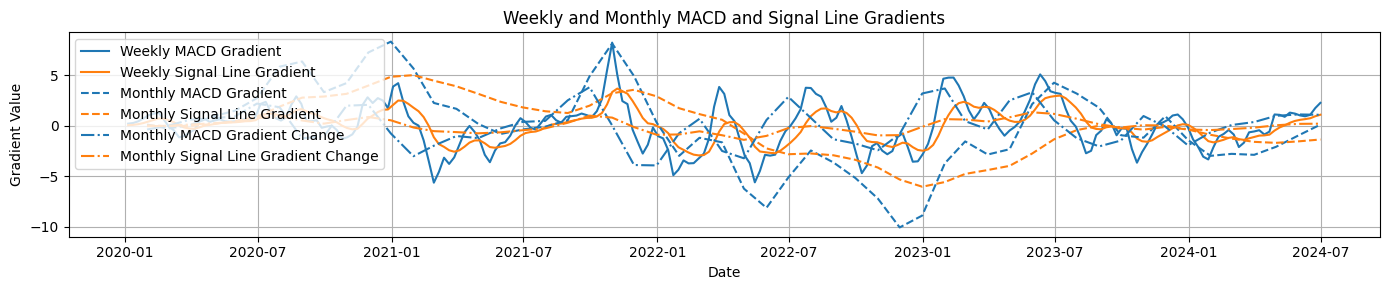

In [580]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime
import numpy as np
from pandas_datareader import fred
from scipy.signal import argrelextrema

def calculate_macd(df, short_window=12, long_window=26, signal_window=9):
    """
    Calculate the MACD and Signal Line indicators
    """
    df['EMA_short'] = df['Close'].ewm(span=short_window, adjust=False).mean()
    df['EMA_long'] = df['Close'].ewm(span=long_window, adjust=False).mean()
    df['MACD'] = df['EMA_short'] - df['EMA_long']
    df['Signal_Line'] = df['MACD'].ewm(span=signal_window, adjust=False).mean()
    return df

def find_exact_crossover_points(df, threshold=0.01):
    """
    Find the exact crossover points where MACD crosses the Signal Line using interpolation
    """
    downcrosses = []
    upcrosses = []
    for i in range(1, len(df)):
        macd_prev = df['MACD'].iloc[i-1]
        signal_prev = df['Signal_Line'].iloc[i-1]
        macd_current = df['MACD'].iloc[i]
        signal_current = df['Signal_Line'].iloc[i]
        
        # Downcrosses
        if macd_prev > signal_prev and macd_current < signal_current:
            if abs(macd_prev - signal_prev) > threshold:
                macd_diff = macd_current - macd_prev
                signal_diff = signal_current - signal_prev
                crossover_time = df.index[i-1] + (df.index[i] - df.index[i-1]) * (macd_prev - signal_prev) / (signal_diff - macd_diff)
                crossover_time = pd.Timestamp(crossover_time).round('D')
                crossover_value = macd_prev + (macd_current - macd_prev) * (crossover_time - df.index[i-1]).total_seconds() / (df.index[i] - df.index[i-1]).total_seconds()
                downcrosses.append((crossover_time, crossover_value))
        
        # Upcrosses
        if macd_prev < signal_prev and macd_current > signal_current:
            if abs(macd_prev - signal_prev) > threshold:
                macd_diff = macd_current - macd_prev
                signal_diff = signal_current - signal_prev
                crossover_time = df.index[i-1] + (df.index[i] - df.index[i-1]) * (signal_prev - macd_prev) / (macd_diff - signal_diff)
                crossover_time = pd.Timestamp(crossover_time).round('D')
                crossover_value = signal_prev + (signal_current - signal_prev) * (crossover_time - df.index[i-1]).total_seconds() / (df.index[i] - df.index[i-1]).total_seconds()
                upcrosses.append((crossover_time, crossover_value))
                
    return downcrosses, upcrosses

def calculate_gradients(df):
    """
    Calculate the gradient (slope) and the rate of change of the gradient of the MACD and Signal Line
    """
    df['MACD_Gradient'] = np.gradient(df['MACD'])
    df['Signal_Line_Gradient'] = np.gradient(df['Signal_Line'])
    df['MACD_Gradient_Change'] = np.gradient(df['MACD_Gradient'])
    df['Signal_Line_Gradient_Change'] = np.gradient(df['Signal_Line_Gradient'])
    return df

def find_nearest_index(df, target_date):
    """
    Find the nearest index to a given date
    """
    return df.index.get_loc(df.index[df.index.get_indexer([target_date], method='nearest')[0]])

def find_selling_point(df_price, df_monthly, purchase_date, downcrosses):
    """
    Find the selling point based on the first overbought signal after purchase, 
    or the first MACD below signal, or the final price of the stock on the graph
    """
    try:
        purchase_index = df_price.index.get_loc(purchase_date)
    except KeyError:
        purchase_index = find_nearest_index(df_price, purchase_date)
        
    subsequent_prices = df_price.iloc[purchase_index:]

    # Look for the first overbought signal
    overbought_dates = df_monthly.index[(df_monthly['MACD'] > df_monthly['Signal_Line']) & 
                                        (df_monthly['MACD'] > 2 * df_monthly['MACD'].std())]
    for date in overbought_dates:
        if date in subsequent_prices.index:
            return date, df_price.loc[date, 'Close']

    # Look for the first MACD below signal
    for date, value in downcrosses:
        if date in subsequent_prices.index:
            return date, df_price.loc[date, 'Close']

    # If no signal is found, return the final price
    final_date = df_price.index[-1]
    return final_date, df_price.loc[final_date, 'Close']

def plot_price_macd(df_price, df_weekly, df_monthly, downcrosses, upcrosses, turning_points, overbought_periods, purchase_date=None, purchase_price=None, show_pl_text=False, include_confidence=False, include_rates=False, consumer_confidence=None, interest_rates=None):
    """
    Plot the stock price along with weekly and monthly MACD indicators, optionally include consumer confidence and interest rates
    """
    if include_confidence and include_rates:
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 16), sharex=True)
    elif include_confidence or include_rates:
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
    else:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
    
    ax1.plot(df_price.index, df_price['Close'], label=f'{ticker} Price', color='black')
    ax1.set_title(f'{ticker} Price')
    ax1.set_ylabel('Price')
    ax1.legend(loc='upper left')
    ax1.grid(True)
    
    # Highlight periods where the monthly MACD gradient is negative
    negative_gradient_periods = df_monthly.index[df_monthly['MACD_Gradient'] < 0]
    for period in negative_gradient_periods:
        ax1.axvspan(period, period + pd.DateOffset(months=1), color='red', alpha=0.3)
    
    # Mark the confirmed turning points on the stock price graph
    for crossover in turning_points:
        nearest_index = find_nearest_index(df_price, crossover[0])
        ax1.scatter(df_price.index[nearest_index], df_price['Close'].iloc[nearest_index], color='green', marker='^', s=100)
        
        # Calculate the price appreciation
        sell_date, sell_price = find_selling_point(df_price, df_monthly, df_price.index[nearest_index], downcrosses)
        buy_price = df_price['Close'].iloc[nearest_index]
        appreciation = (sell_price - buy_price) / buy_price * 100
        # Add text annotation for price appreciation, shifted to the right and up
        ax1.text(df_price.index[nearest_index] + pd.DateOffset(days=15), df_price['Close'].iloc[nearest_index] * 1.05, f'{appreciation:.1f}%', fontsize=8, color='green')

    # Mark the exact crossover points where the monthly MACD falls below the monthly Signal line with red circles
    for crossover in downcrosses:
        nearest_index = find_nearest_index(df_price, crossover[0])
        ax1.scatter(df_price.index[nearest_index], df_price['Close'].iloc[nearest_index], color='red', marker='o', s=100)
    
    # Mark the exact crossover points where the monthly MACD crosses above the monthly Signal line with green circles
    for crossover in upcrosses:
        nearest_index = find_nearest_index(df_price, crossover[0])
        ax1.scatter(df_price.index[nearest_index], df_price['Close'].iloc[nearest_index], color='green', marker='o', s=100)
    
    # Mark overbought conditions on the stock price graph
    for start, end in overbought_periods:
        overbought_dates = df_price.loc[start:end].index
        ax1.scatter(overbought_dates, df_price.loc[overbought_dates, 'Close'], color='red', marker='x', s=100, label='Overbought')
    
    if purchase_date and purchase_price:
        # Add marker for manual purchase price
        nearest_index = find_nearest_index(df_price, purchase_date)
        ax1.scatter(df_price.index[nearest_index], purchase_price, color='blue', marker='s', s=100, label='Purchase Price')
        
        if show_pl_text:
            # Calculate and display current profit/loss based on the new selling point criteria
            sell_date, sell_price = find_selling_point(df_price, df_monthly, df_price.index[nearest_index], downcrosses)
            profit_loss = (sell_price - purchase_price) / purchase_price * 100
            ax1.text(0.95, 0.95, f'Current P/L: {profit_loss:.1f}%', transform=ax1.transAxes, fontsize=12, color='blue', ha='right', va='top')

    # Calculate and display profit/loss if bought at start date and held until end date
    start_price = df_price['Close'].iloc[0]
    end_price = df_price['Close'].iloc[-1]
    hold_pl = (end_price - start_price) / start_price * 100
    ax1.text(0.95, 0.85, f'Hold P/L: {hold_pl:.1f}%', transform=ax1.transAxes, fontsize=12, color='blue', ha='right', va='top')

    ax2.plot(df_weekly.index, df_weekly['MACD'], label='Weekly MACD', color='tab:blue', linewidth=1.5)
    ax2.plot(df_weekly.index, df_weekly['Signal_Line'], label='Weekly Signal Line', color='tab:orange', linestyle='-', linewidth=1.5)
    ax2.bar(df_weekly.index, df_weekly['MACD'] - df_weekly['Signal_Line'], label='Weekly MACD Histogram', color='grey', alpha=0.5)
    
    ax2.plot(df_monthly.index, df_monthly['MACD'], label='Monthly MACD', color='tab:blue', linestyle='--', linewidth=1.5)
    ax2.plot(df_monthly.index, df_monthly['Signal_Line'], label='Monthly Signal Line', color='tab:orange', linestyle='--', linewidth=1.5)
    
    # Mark the exact crossover points where the monthly MACD falls below the monthly Signal line
    downcross_dates = [date for date, value in downcrosses]
    downcross_values = [value for date, value in downcrosses]
    ax2.scatter(downcross_dates, downcross_values, color='red', marker='o', s=100, label='MACD below Signal')
    
    # Mark the exact crossover points where the monthly MACD crosses above the monthly Signal line
    upcross_dates = [date for date, value in upcrosses]
    upcross_values = [value for date, value in upcrosses]
    ax2.scatter(upcross_dates, upcross_values, color='green', marker='o', s=100, label='MACD above Signal')
    
    # Mark the turning points on the MACD graph
    turning_point_dates = [date for date, value in turning_points]
    turning_point_values = [value for date, value in turning_points]
    ax2.scatter(turning_point_dates, turning_point_values, color='green', marker='^', s=100, label='Turning Points')
    
    # Highlight regions where the weekly MACD is below the signal line
    ax2.fill_between(df_weekly.index, df_weekly['MACD'], df_weekly['Signal_Line'], 
                     where=(df_weekly['MACD'] < df_weekly['Signal_Line']), 
                     color='red', alpha=0.3, label='MACD below Signal')
    
    # Highlight regions where the weekly MACD has a negative gradient
    ax2.fill_between(df_weekly.index, df_weekly['MACD'], 
                     where=(df_weekly['MACD_Gradient'] < 0), 
                     color='grey', alpha=0.3, label='Negative Gradient')
    
    # Mark overbought/oversold conditions on the monthly MACD graph
    overbought_dates = df_monthly.index[
        (df_monthly['MACD'] > df_monthly['Signal_Line']) & 
        (df_monthly['MACD_Gradient'] < 0) & 
        (aligned_weekly['MACD_weekly'] < aligned_weekly['Signal_Line_weekly'])
    ]
    oversold_dates = df_monthly.index[
        (df_monthly['MACD'] < df_monthly['Signal_Line']) & 
        (df_monthly['MACD'] < -2 * df_monthly['MACD'].std()) & 
        (aligned_weekly['MACD_Gradient_weekly'] < 0)
    ]
    ax2.scatter(overbought_dates, df_monthly.loc[overbought_dates, 'MACD'], color='red', marker='x', s=100, label='Overbought')
    ax2.scatter(oversold_dates, df_monthly.loc[oversold_dates, 'MACD'], color='green', marker='x', s=100, label='Oversold')
    
    ax2.set_title('MACD Indicators')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('MACD Value')
    ax2.legend(loc='upper left')
    ax2.grid(True)
    
    if include_confidence:
        # Highlight regions where the monthly MACD gradient is negative and MACD is below the signal line on the consumer confidence graph
        negative_gradient_periods = df_monthly.index[(df_monthly['MACD_Gradient'] < 0) & (df_monthly['MACD'] < df_monthly['Signal_Line'])]
        for period in negative_gradient_periods:
            ax3.axvspan(period, period + pd.DateOffset(months=1), color='red', alpha=0.3)
        
        ax3.plot(consumer_confidence.index, consumer_confidence['Consumer_Confidence'], label='Consumer Confidence', color='tab:blue', linestyle='-', linewidth=1.5)
        ax3.set_title('Consumer Confidence in the Stock Market')
        ax3.set_xlabel('Date')
        ax3.set_ylabel('Consumer Confidence Index')
        ax3.legend(loc='upper left')
        ax3.grid(True)
    
    if include_rates:
        ax4.plot(interest_rates.index, interest_rates['Interest_Rates'], label='Interest Rates', color='tab:green', linestyle='-', linewidth=1.5)
        ax4.set_title('Interest Rates')
        ax4.set_xlabel('Date')
        ax4.set_ylabel('Interest Rates')
        ax4.legend(loc='upper left')
        ax4.grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_gradients(df_weekly, df_monthly):
    """
    Plot the gradients of the weekly and monthly MACD and Signal Line
    """
    fig, ax = plt.subplots(figsize=(14, 3))  # Adjusted height to 3
    
    ax.plot(df_weekly.index, df_weekly['MACD_Gradient'], label='Weekly MACD Gradient', color='tab:blue', linewidth=1.5)
    ax.plot(df_weekly.index, df_weekly['Signal_Line_Gradient'], label='Weekly Signal Line Gradient', color='tab:orange', linestyle='-', linewidth=1.5)
    
    ax.plot(df_monthly.index, df_monthly['MACD_Gradient'], label='Monthly MACD Gradient', color='tab:blue', linestyle='--', linewidth=1.5)
    ax.plot(df_monthly.index, df_monthly['Signal_Line_Gradient'], label='Monthly Signal Line Gradient', color='tab:orange', linestyle='--', linewidth=1.5)
    
    ax.plot(df_monthly.index, df_monthly['MACD_Gradient_Change'], label='Monthly MACD Gradient Change', color='tab:blue', linestyle='-.', linewidth=1.5)
    ax.plot(df_monthly.index, df_monthly['Signal_Line_Gradient_Change'], label='Monthly Signal Line Gradient Change', color='tab:orange', linestyle='-.', linewidth=1.5)
    
    ax.set_title('Weekly and Monthly MACD and Signal Line Gradients')
    ax.set_xlabel('Date')
    ax.set_ylabel('Gradient Value')
    ax.legend(loc='upper left')
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    ticker = 'TSLA'
    start_date = '2020-01-01'
    end_date = datetime.today().strftime('%Y-%m-%d')
    df = yf.download(ticker, start=start_date, end=end_date)
    
    df_weekly = df.resample('W').last()
    df_monthly = df.resample('M').last()
    
    df_weekly = calculate_macd(df_weekly)
    df_monthly = calculate_macd(df_monthly)
    
    df_weekly = calculate_gradients(df_weekly)
    df_monthly = calculate_gradients(df_monthly)
    
    downcrosses, upcrosses = find_exact_crossover_points(df_monthly)
    
    # Align the weekly data with the monthly data using merge_asof
    aligned_weekly = pd.merge_asof(df_monthly, df_weekly, left_index=True, right_index=True, suffixes=('_monthly', '_weekly'))
    
    # Find turning points in the weekly MACD where the MACD is negative, crosses above the signal line, and monthly MACD is negative
    turning_points = []
    for i in range(1, len(df_weekly)):
        if df_weekly['MACD'].iloc[i] < 0 and df_weekly['MACD'].iloc[i-1] < df_weekly['Signal_Line'].iloc[i-1] and df_weekly['MACD'].iloc[i] > df_weekly['Signal_Line'].iloc[i]:
            nearest_monthly_index = find_nearest_index(df_monthly, df_weekly.index[i])
            if df_monthly['MACD'].iloc[nearest_monthly_index] < 0:
                turning_points.append((df_weekly.index[i], df_weekly['MACD'].iloc[i]))
    
    # Identify overbought periods based on monthly MACD
    overbought_periods = []
    overbought_dates = df_monthly.index[
        (df_monthly['MACD'] > df_monthly['Signal_Line']) & 
        (df_monthly['MACD_Gradient'] < 0) & 
        (aligned_weekly['MACD_weekly'] < aligned_weekly['Signal_Line_weekly'])
    ]
    if len(overbought_dates) > 1:
        start = overbought_dates[0]
        for i in range(1, len(overbought_dates)):
            if (overbought_dates[i] - overbought_dates[i-1]).days > 1:
                end = overbought_dates[i-1]
                overbought_periods.append((start, end))
                start = overbought_dates[i]
        overbought_periods.append((start, overbought_dates[-1]))
    
    # Include oversold periods based on the modified condition
    oversold_periods = []
    oversold_dates = df_monthly.index[
        (df_monthly['MACD'] < df_monthly['Signal_Line']) & 
        (df_monthly['MACD'] < -2 * df_monthly['MACD'].std()) & 
        (aligned_weekly['MACD_Gradient_weekly'] < 0)
    ]
    if len(oversold_dates) > 1:
        start = oversold_dates[0]
        for i in range(1, len(oversold_dates)):
            if (oversold_dates[i] - oversold_dates[i-1]).days > 1:
                end = oversold_dates[i-1]
                oversold_periods.append((start, end))
                start = oversold_dates[i]
        oversold_periods.append((start, oversold_dates[-1]))

    include_confidence = True
    include_rates = True
    
    if include_confidence:
        # Fetch consumer confidence data from FRED (University of Michigan: Consumer Sentiment)
        consumer_confidence_series_id = 'UMCSENT'  # University of Michigan: Consumer Sentiment
        consumer_confidence = fred.FredReader(consumer_confidence_series_id, start=start_date, end=end_date).read()
        consumer_confidence.rename(columns={consumer_confidence_series_id: 'Consumer_Confidence'}, inplace=True)
    else:
        consumer_confidence = None
    
    if include_rates:
        # Fetch interest rate data from FRED
        interest_rate_series_id = 'DFF'  # Effective Federal Funds Rate
        interest_rates = fred.FredReader(interest_rate_series_id, start=start_date, end=end_date).read()
        interest_rates.rename(columns={interest_rate_series_id: 'Interest_Rates'}, inplace=True)
    else:
        interest_rates = None
    
    # Define manual purchase date and price
    purchase_date = pd.Timestamp('2024-06-30')
    purchase_price = 198.95
    
    plot_price_macd(df, df_weekly, df_monthly, downcrosses, upcrosses, turning_points, overbought_periods, purchase_date, purchase_price, show_pl_text=True, include_confidence=include_confidence, include_rates=include_rates, consumer_confidence=consumer_confidence, interest_rates=interest_rates)
    plot_gradients(df_weekly, df_monthly)

[*********************100%%**********************]  1 of 1 completed


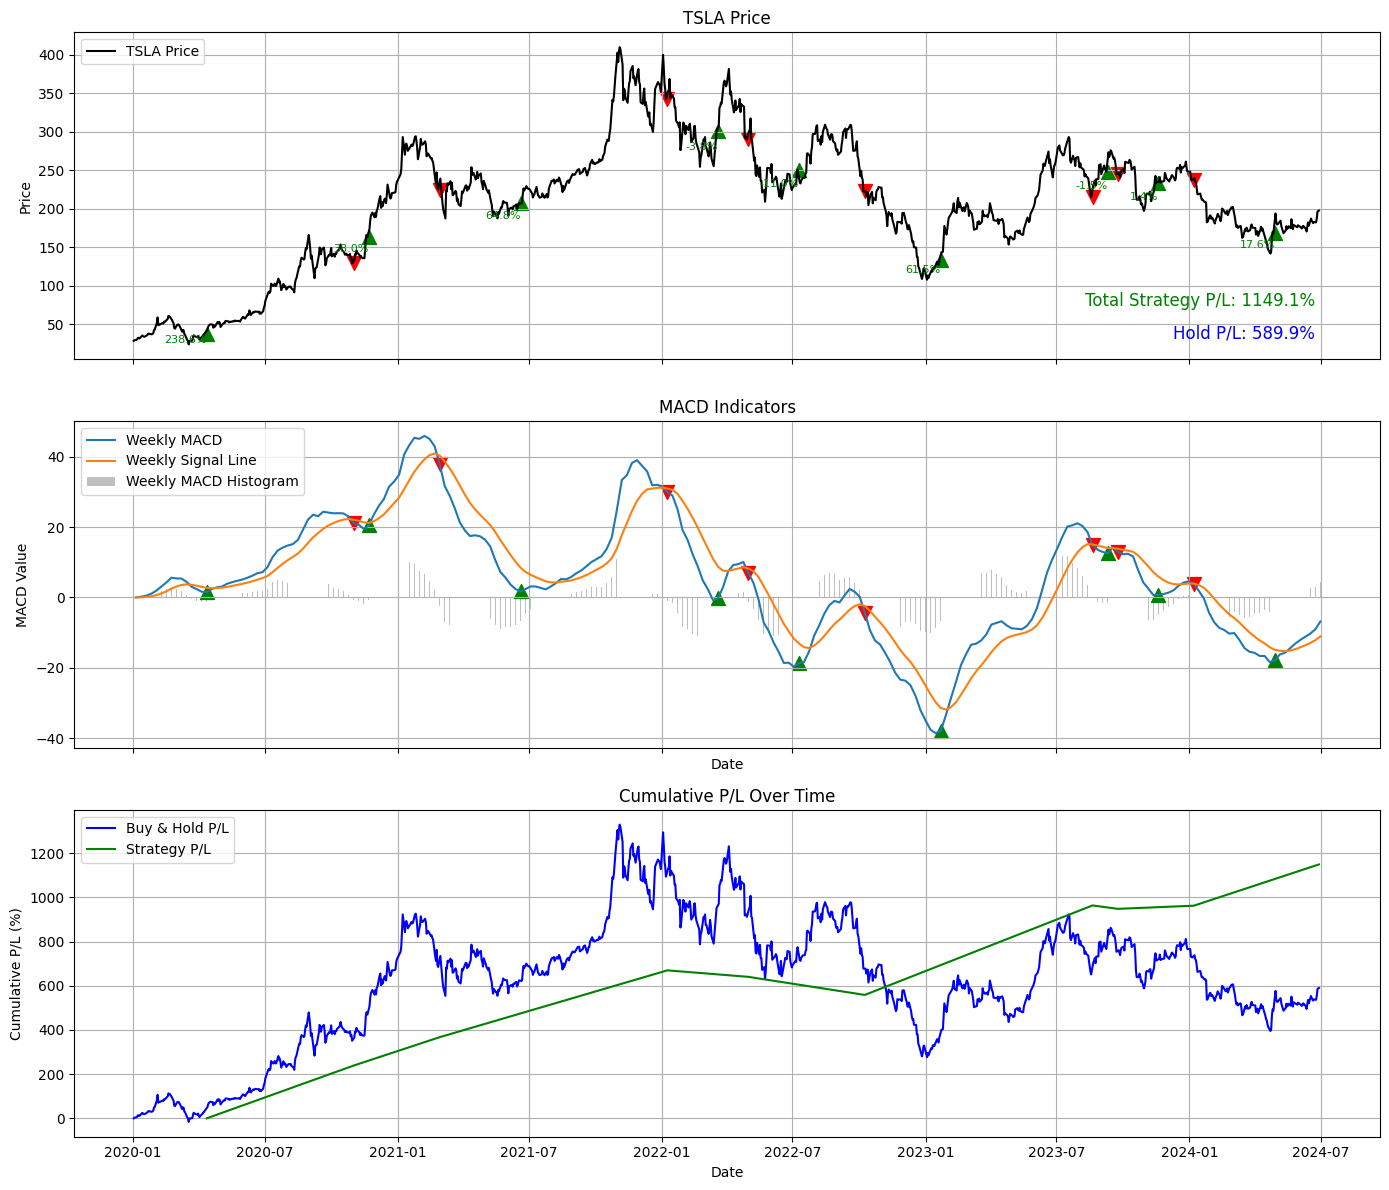

    Buy Date  Sell Date   Buy Price  Sell Price     P/L (%)
0 2020-04-12 2020-11-01   38.200001  129.346664  238.603827
1 2020-11-22 2021-02-28  163.203339  225.166672   37.966952
2 2021-06-20 2022-01-09  207.770004  342.320007   64.759109
3 2022-03-20 2022-05-01  301.796661  290.253326   -3.824872
4 2022-07-10 2022-10-09  250.763336  223.070007  -11.043612
5 2023-01-22 2023-08-20  133.419998  215.490005   61.512523
6 2023-09-10 2023-09-24  248.500000  244.880005   -1.456738
7 2023-11-19 2024-01-07  234.300003  237.490005    1.361503
8 2024-04-28 2024-06-28  168.289993  197.880005   17.582752


In [637]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime
import numpy as np

def calculate_macd(df, short_window=12, long_window=26, signal_window=9):
    """
    Calculate the MACD and Signal Line indicators
    """
    df['EMA_short'] = df['Close'].ewm(span=short_window, adjust=False).mean()
    df['EMA_long'] = df['Close'].ewm(span=long_window, adjust=False).mean()
    df['MACD'] = df['EMA_short'] - df['EMA_long']
    df['Signal_Line'] = df['MACD'].ewm(span=signal_window, adjust=False).mean()
    return df

def calculate_gradients(df):
    """
    Calculate the gradient (slope) of the MACD and Signal Line
    """
    df['MACD_Gradient'] = np.gradient(df['MACD'])
    return df

def find_turning_points(df):
    """
    Find turning points in the MACD and its gradient
    """
    turning_points_buy = []
    turning_points_sell = []
    
    for i in range(1, len(df)-1):
        # Buy condition: MACD gradient turns positive from negative
        if df['MACD_Gradient'].iloc[i-1] < 0 and df['MACD_Gradient'].iloc[i] >= 0:
            turning_points_buy.append((df.index[i], df['Close'].iloc[i], df['MACD'].iloc[i]))
        
        # Sell condition: MACD turns negative from positive
        if df['MACD'].iloc[i-1] > df['Signal_Line'].iloc[i-1] and df['MACD'].iloc[i] < df['Signal_Line'].iloc[i]:
            turning_points_sell.append((df.index[i], df['Close'].iloc[i], df['MACD'].iloc[i]))
    
    return turning_points_buy, turning_points_sell

def filter_signals(buy_signals, sell_signals):
    """
    Filter buy and sell signals to ensure proper sequence
    """
    filtered_buy_signals = []
    filtered_sell_signals = []
    
    last_sell_date = None
    
    for buy_signal in buy_signals:
        if last_sell_date is None or buy_signal[0] > last_sell_date:
            filtered_buy_signals.append(buy_signal)
            corresponding_sell_signal = next((sell_signal for sell_signal in sell_signals if sell_signal[0] > buy_signal[0]), None)
            if corresponding_sell_signal:
                filtered_sell_signals.append(corresponding_sell_signal)
                last_sell_date = corresponding_sell_signal[0]
    
    return filtered_buy_signals, filtered_sell_signals

def calculate_profit_loss(buy_signals, sell_signals, df_price):
    """
    Calculate the profit/loss based on buy and sell signals
    """
    profit_loss = []
    cumulative_pl = []
    capital = 100  # Starting capital (arbitrary value for percentage calculation)
    
    trade_dates = []

    for i in range(len(buy_signals)):
        buy_price = buy_signals[i][1]
        if i < len(sell_signals):
            sell_price = sell_signals[i][1]
            sell_date = sell_signals[i][0]
        else:
            sell_price = df_price['Close'].iloc[-1]
            sell_date = df_price.index[-1]
        pl = (sell_price - buy_price) / buy_price * 100
        capital *= (1 + pl / 100)
        profit_loss.append(pl)
        cumulative_pl.append(capital - 100)
        trade_dates.append((buy_signals[i][0], sell_date))
    
    # Calculate hold profit/loss
    start_price = df_price['Close'].iloc[0]
    end_price = df_price['Close'].iloc[-1]
    hold_pl = (end_price - start_price) / start_price * 100
    
    return profit_loss, hold_pl, cumulative_pl, trade_dates

def plot_price_macd(df_price, df_weekly, buy_signals, sell_signals, profit_loss, hold_pl, cumulative_pl, trade_dates):
    """
    Plot the stock price along with weekly MACD indicators and cumulative P/L
    """
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
    
    ax1.plot(df_price.index, df_price['Close'], label=f'{ticker} Price', color='black')
    ax1.set_title(f'{ticker} Price')
    ax1.set_ylabel('Price')
    ax1.legend(loc='upper left')
    ax1.grid(True)
    
    # Mark the buy signals on the stock price graph
    for date, price, macd_value in buy_signals:
        ax1.scatter(date, price, color='green', marker='^', s=100, label='Buy Signal')
    
    # Mark the sell signals on the stock price graph
    for date, price, macd_value in sell_signals:
        ax1.scatter(date, price, color='red', marker='v', s=100, label='Sell Signal')
    
    # Calculate and display profit/loss if bought at the first buy signal and sold at subsequent sell signals
    for i, pl in enumerate(profit_loss):
        ax1.text(buy_signals[i][0], buy_signals[i][1] * 0.95, f'{pl:.1f}%', fontsize=8, color='green', ha='right', va='top')
    
    # Calculate and display profit/loss if bought at start date and held until end date
    ax1.text(0.95, 0.05, f'Hold P/L: {hold_pl:.1f}%', transform=ax1.transAxes, fontsize=12, color='blue', ha='right', va='bottom')
    
    # Display total P/L from buy/sell strategy
    ax1.text(0.95, 0.15, f'Total Strategy P/L: {cumulative_pl[-1]:.1f}%', transform=ax1.transAxes, fontsize=12, color='green', ha='right', va='bottom')

    ax2.plot(df_weekly.index, df_weekly['MACD'], label='Weekly MACD', color='tab:blue', linewidth=1.5)
    ax2.plot(df_weekly.index, df_weekly['Signal_Line'], label='Weekly Signal Line', color='tab:orange', linestyle='-', linewidth=1.5)
    ax2.bar(df_weekly.index, df_weekly['MACD'] - df_weekly['Signal_Line'], label='Weekly MACD Histogram', color='grey', alpha=0.5)
    
    # Mark the buy signals on the MACD graph
    for date, price, macd_value in buy_signals:
        ax2.scatter(date, macd_value, color='green', marker='^', s=100)
    
    # Mark the sell signals on the MACD graph
    for date, price, macd_value in sell_signals:
        ax2.scatter(date, macd_value, color='red', marker='v', s=100)
    
    ax2.set_title('MACD Indicators')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('MACD Value')
    ax2.legend(loc='upper left')
    ax2.grid(True)
    
    # Plot cumulative P/L over time
    ax3.plot(df_price.index, (df_price['Close'] / df_price['Close'].iloc[0] - 1) * 100, label='Buy & Hold P/L', color='blue')
    strategy_dates = [trade[1] for trade in trade_dates]
    strategy_dates.insert(0, trade_dates[0][0])
    cumulative_pl.insert(0, 0)
    ax3.plot(strategy_dates, cumulative_pl, label='Strategy P/L', color='green')
    ax3.set_title('Cumulative P/L Over Time')
    ax3.set_xlabel('Date')
    ax3.set_ylabel('Cumulative P/L (%)')
    ax3.legend(loc='upper left')
    ax3.grid(True)
    
    plt.tight_layout()
    plt.show()

    # Create a table of trades and their profit/loss
    trade_data = {
        'Buy Date': [trade[0] for trade in trade_dates],
        'Sell Date': [trade[1] for trade in trade_dates],
        'Buy Price': [buy_signals[i][1] for i in range(len(buy_signals))],
        'Sell Price': [sell_signals[i][1] if i < len(sell_signals) else df_price['Close'].iloc[-1] for i in range(len(buy_signals))],
        'P/L (%)': profit_loss
    }
    trade_df = pd.DataFrame(trade_data)
    print(trade_df)

if __name__ == "__main__":
    ticker = 'TSLA'
    start_date = '2020-01-01'
    end_date = datetime.today().strftime('%Y-%m-%d')
    df = yf.download(ticker, start=start_date, end=end_date)
    
    df_weekly = df.resample('W').last()
    
    df_weekly = calculate_macd(df_weekly)
    df_weekly = calculate_gradients(df_weekly)
    
    buy_signals, sell_signals = find_turning_points(df_weekly)
    
    filtered_buy_signals, filtered_sell_signals = filter_signals(buy_signals, sell_signals)
    
    profit_loss, hold_pl, cumulative_pl, trade_dates = calculate_profit_loss(filtered_buy_signals, filtered_sell_signals, df)
    
    plot_price_macd(df, df_weekly, filtered_buy_signals, filtered_sell_signals, profit_loss, hold_pl, cumulative_pl, trade_dates)
